## Dataset Link: https://www.kaggle.com/manishshah120/facial-expression-recog-image-ver-of-fercdataset

In [1]:
project_name = 'face-exp-resnet'

In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
from PIL import Image
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.models as models
%matplotlib inline

In [3]:
data_dir = 'E:\projects\Machine Learning R_27.07.21\Machine Learning Project 21 - Face Expression Identifier\Dataset'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)
len

['labels.txt', 'test', 'train']
['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


<function len(obj, /)>

In [4]:
len(os.listdir('E:\projects\Machine Learning R_27.07.21\Machine Learning Project 21 - Face Expression Identifier\Dataset/train/sadness'))

5483

In [5]:
train_tfms = tt.Compose([
#                          tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
                         tt.ColorJitter(brightness=0.1, contrast=0.25, saturation=0.35, hue=0.05),
                         tt.RandomRotation(10, expand=False, center=None, fill=None),
                         tt.ToTensor()
                        ])

valid_tfms = tt.Compose([tt.ToTensor()])

In [6]:
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [9]:
batch_size = 256

In [10]:
train_dl = DataLoader(
    train_ds, 
    batch_size, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True
                     )

valid_dl = DataLoader(
    valid_ds, 
    batch_size*2, 
    num_workers=4, 
    pin_memory=True
                     )

In [11]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([]) 
        ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=16).permute(1, 2, 0))
        break

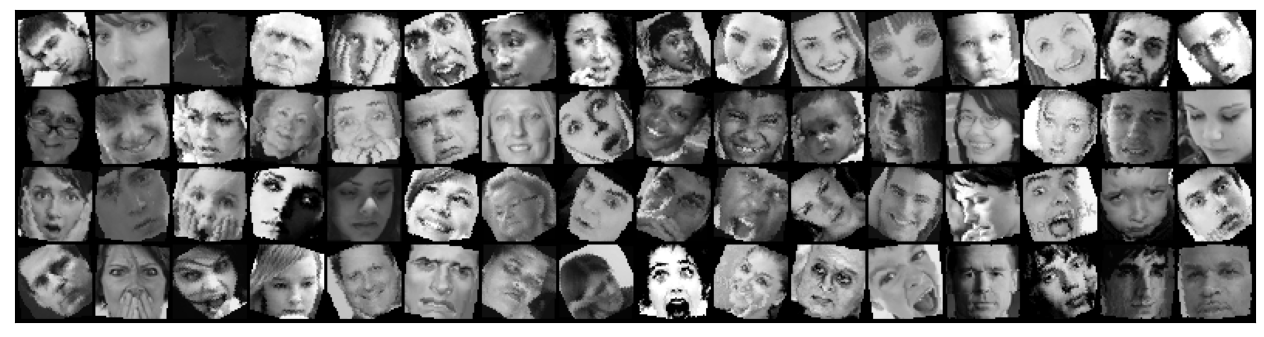

In [12]:
show_batch(train_dl)

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cpu')

In [15]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [17]:
class ResNet18(ImageClassification):
    def __init__(self, num_classes):
        super().__init__()
        
        self.network = models.resnet18(pretrained=True)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x):
        return self.network(x)

In [18]:
model = ResNet18(7)
model = to_device(model, device)

c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
pip install jovian --upgrade

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
from tqdm.notebook import tqdm

In [21]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.985182285308838, 'val_acc': 0.20395508408546448}]

In [23]:
epochs = 25
max_lr = 0.05
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [24]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.00405, train_loss: 1.5669, val_loss: 1.5168, val_acc: 0.4251


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00990, train_loss: 1.5458, val_loss: 3.9857, val_acc: 0.3152


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.01854, train_loss: 1.7932, val_loss: 1.7522, val_acc: 0.3470


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.02847, train_loss: 1.6177, val_loss: 1.5890, val_acc: 0.3882


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.03798, train_loss: 1.5139, val_loss: 1.5806, val_acc: 0.4219


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.04541, train_loss: 1.4850, val_loss: 1.9459, val_acc: 0.1602


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.04947, train_loss: 1.4617, val_loss: 2.0060, val_acc: 0.2951


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.04990, train_loss: 1.4525, val_loss: 2.1217, val_acc: 0.2769


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.04910, train_loss: 1.4375, val_loss: 2.2289, val_acc: 0.3249


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.04752, train_loss: 1.4187, val_loss: 1.7036, val_acc: 0.3513


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.04523, train_loss: 1.4138, val_loss: 1.5985, val_acc: 0.4518


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.04228, train_loss: 1.3980, val_loss: 1.6205, val_acc: 0.3737


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.03877, train_loss: 1.3867, val_loss: 1.4192, val_acc: 0.4835


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.03483, train_loss: 1.3789, val_loss: 1.4093, val_acc: 0.4604


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.03056, train_loss: 1.3573, val_loss: 1.3096, val_acc: 0.5092


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.02612, train_loss: 1.3404, val_loss: 1.8721, val_acc: 0.3041


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.02164, train_loss: 1.3298, val_loss: 1.4957, val_acc: 0.4269


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.01727, train_loss: 1.3024, val_loss: 1.5477, val_acc: 0.4093


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.01315, train_loss: 1.2781, val_loss: 1.1214, val_acc: 0.5666


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00941, train_loss: 1.2532, val_loss: 1.1834, val_acc: 0.5585


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00617, train_loss: 1.2232, val_loss: 1.1597, val_acc: 0.5529


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [21], last_lr: 0.00354, train_loss: 1.1854, val_loss: 1.0661, val_acc: 0.5944


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [22], last_lr: 0.00159, train_loss: 1.1531, val_loss: 1.0206, val_acc: 0.6139


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [23], last_lr: 0.00040, train_loss: 1.1275, val_loss: 1.0037, val_acc: 0.6154


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [24], last_lr: 0.00000, train_loss: 1.1134, val_loss: 1.0048, val_acc: 0.6142
CPU times: total: 20h 8min
Wall time: 10h 54min 57s


In [25]:
def plot_acc(history):
    acc = [x['val_acc'] for x in history]
    plt.plot(acc,'-x')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. no. of epochs')

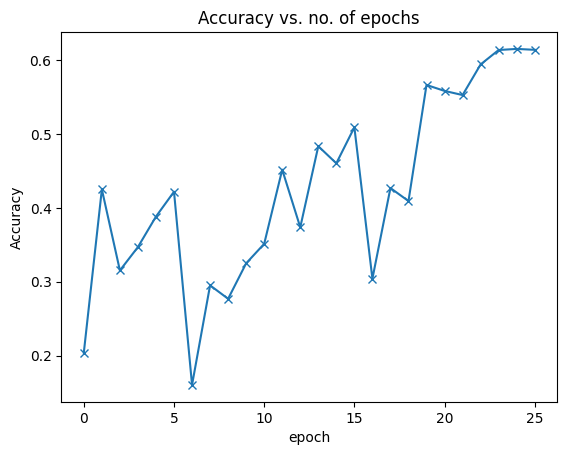

In [26]:
plot_acc(history)

In [27]:
def plot_losses(history):
    train_loss = [x.get('train_loss') for x in history]
    val_loss = [x['val_loss'] for x in history]
    plt.plot(train_loss, '-bx')
    plt.plot(val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend('Training', 'Validation')

C:\Users\Hp\AppData\Local\Temp\ipykernel_13756\1029045736.py:8: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Training', 'Validation')


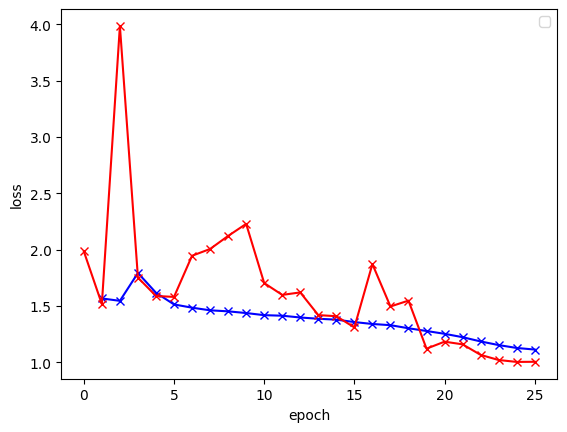

In [28]:
plot_losses(history)

In [29]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs',[]) for x in history])
    plt.plot(lrs)
    plt.xlabel('epoch')
    plt.ylabel('learning rate')
    plt.title('Learning Rate vs. no. of epochs')

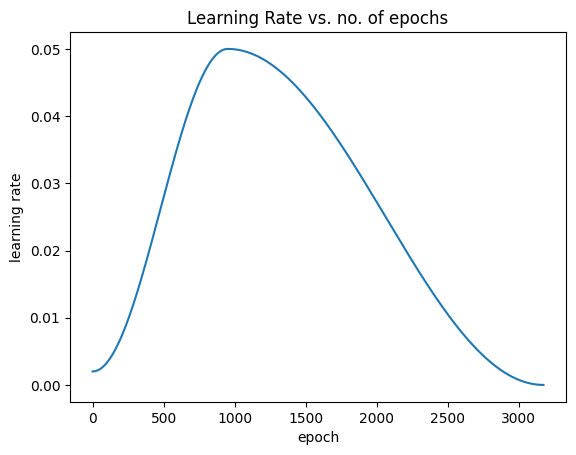

In [30]:
plot_lrs(history)